In [231]:
import os
import sys
import time
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '/Users/lydiazoghbi/Desktop/Skin Detection/Segmentation/Skin_Datasets/Dataset1_HGR/original_images/'
MASK_PATH = '/Users/lydiazoghbi/Desktop/Skin Detection/Segmentation/Skin_Datasets/Dataset1_HGR/skin_masks/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [92]:
# Get train and mask IDs
train_id = next(os.walk(TRAIN_PATH))[2]
mask_ids = next(os.walk(MASK_PATH))[2]

train_id.sort()
train_ids = train_id[1:] #In case some weird crap .DStore file popped up
mask_ids.sort()

In [ ]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
    path = MASK_PATH + id_
    img = imread(path)
    img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    Y_train[n] = img
    
print('Done!')

In [179]:
# Check if training masks match ground truth
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

Getting and resizing train images and masks ... 


100%|██████████| 899/899 [00:01<00:00, 543.16it/s]

Done!


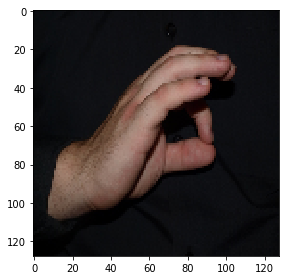

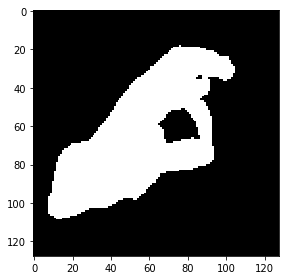

In [227]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [100]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [103]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 128, 128, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 128, 128, 16) 448         lambda_4[0][0]                   
__________________________________________________________________________________________________
dropout_28 (Dropout)            (None, 128, 128, 16) 0           conv2d_58[0][0]                  
__________________________________________________________________________________________________
conv2d_59 

In [ ]:
# Define class for extracting time per epoch
class TimingCallback(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

cb = TimingCallback()   

In [104]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=5, 
                    callbacks=[earlystopper, checkpointer, cb])

Train on 809 samples, validate on 90 samples
Epoch 1/50
809/809 [==============================] - 98s 121ms/step - loss: 0.2696 - mean_iou: 0.5146 - val_loss: 0.3446 - val_mean_iou: 0.6573

Epoch 00001: val_loss improved from inf to 0.34456, saving model to model-dsbowl2018-1.h5
Epoch 2/50
809/809 [==============================] - 96s 119ms/step - loss: 0.0962 - mean_iou: 0.7187 - val_loss: 0.1427 - val_mean_iou: 0.7603

Epoch 00002: val_loss improved from 0.34456 to 0.14273, saving model to model-dsbowl2018-1.h5
Epoch 3/50
809/809 [==============================] - 95s 118ms/step - loss: 0.0842 - mean_iou: 0.7806 - val_loss: 0.0784 - val_mean_iou: 0.8008

Epoch 00003: val_loss improved from 0.14273 to 0.07844, saving model to model-dsbowl2018-1.h5
Epoch 4/50
809/809 [==============================] - 94s 116ms/step - loss: 0.0668 - mean_iou: 0.8158 - val_loss: 0.0730 - val_mean_iou: 0.8275

Epoch 00004: val_loss improved from 0.07844 to 0.07299, saving model to model-dsbowl2018-1.h5

In [ ]:
#print(results.history.keys())

# Summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for mean_iou
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model mean iou')
plt.ylabel('mean_iou')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Results and Plots
# model.summary()
print("UNET ARCHITECTURE")
print ("-------------------------------------------------------------")
print("Max num of epochs: %d" % 50)
print("Optimizer: %s" % 'ADAM')
print("Batch size: %d" % 16)
print("Loss function: %s" % 'Binary Cross-Entropy')
print("Validation data percentage: %d" % 10)
print("Early stoppping: %s" % 'Yes')

ep = 5;
a = results.history["acc"]
b = results.history["loss"]
c = results.history["val_acc"]
d = results.history["val_loss"]
e = cb.times
print ("-------------------------------------------------------------")
header = "#"+"    "+"Time sec"+"      "+"Tr_acc"+"     "+"Tr_loss"+"      "+"Vl_acc"+"     "+"Vl_loss"
print(header)
print ("-------------------------------------------------------------")
for l in range(ep):
    str = "%d\t\t%f\t\t%f\t\t%f\t\t%f\t\t%f" % (l, round(e[l],4),round(a[l],4),round(b[l],4),round(c[l],4),d[l])
    print (str.expandtabs(2))
print ("-------------------------------------------------------------")

In [107]:
# Predict on train and validation tests
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)


90/90 [==============================] - 4s 43ms/step


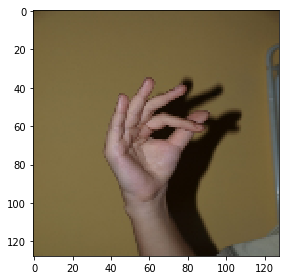

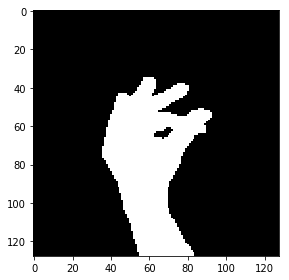

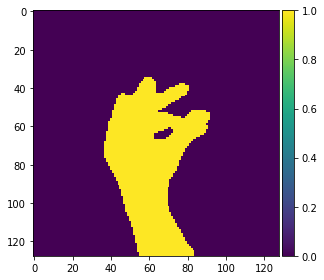

In [110]:
# Sanity check on random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

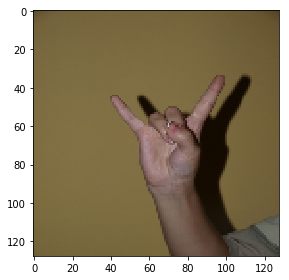

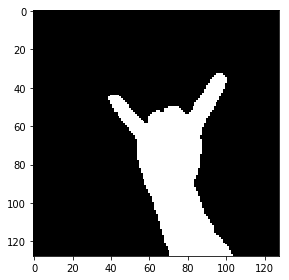

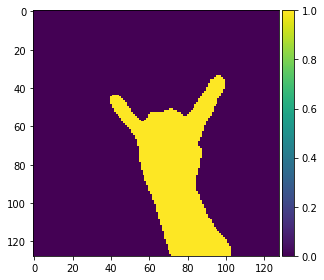

In [119]:
# Sanity check on random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [228]:
# Test Against Abdomen Pictures
TEST_PATH = '/Users/lydiazoghbi/Desktop/Skin Detection/testing data/'
test_id = next(os.walk(TEST_PATH))[2]
test_id.sort()

test = np.zeros((len(test_id), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_id), total=len(test_id)):
    path = TEST_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    test[n] = img
    
# Actual Predictions
preds_test = model.predict(test[:int(test.shape[0])], verbose=1)

# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

100%|██████████| 50/50 [00:01<00:00, 26.94it/s]


50/50 [==============================] - 2s 45ms/step


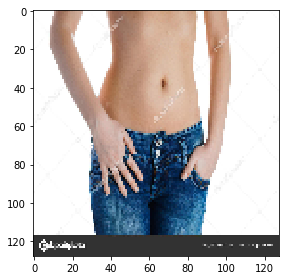

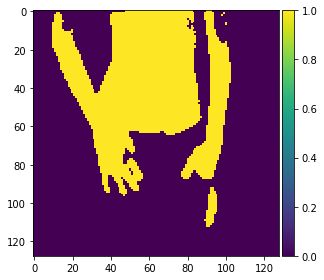

In [229]:
# Visualize Predictions
ix = random.randint(0, len(test_id))
imshow(test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()